### Checking for duplicates, missing observations, and outliers

#### Duplicates

In [1]:
df = spark.createDataFrame([
        (1, 144.5, 5.9, 33, 'M'),
        (2, 167.2, 5.4, 45, 'M'),
        (3, 124.1, 5.2, 23, 'F'),
        (4, 144.5, 5.9, 33, 'M'),
        (5, 133.2, 5.7, 54, 'F'),
        (3, 124.1, 5.2, 23, 'F'),
        (5, 129.2, 5.3, 42, 'M'),
    ], ['id', 'weight', 'height', 'age', 'gender'])

In [2]:
print('Count of rows: {0}'.format(df.count()))
print('Count of distinct rows: {0}'.format(df.distinct().count()))

Count of rows: 7
Count of distinct rows: 6


In [3]:
df = df.dropDuplicates()
df.show()

+---+------+------+---+------+
| id|weight|height|age|gender|
+---+------+------+---+------+
|  5| 133.2|   5.7| 54|     F|
|  5| 129.2|   5.3| 42|     M|
|  1| 144.5|   5.9| 33|     M|
|  4| 144.5|   5.9| 33|     M|
|  2| 167.2|   5.4| 45|     M|
|  3| 124.1|   5.2| 23|     F|
+---+------+------+---+------+



In [4]:
print('Count of ids: {0}'.format(df.count()))
print('Count of distinct ids: {0}'.format(df.select([c for c in df.columns if c != 'id']).distinct().count()))

Count of ids: 6
Count of distinct ids: 5


In [5]:
df = df.dropDuplicates(subset=[c for c in df.columns if c != 'id'])
df.show()

+---+------+------+---+------+
| id|weight|height|age|gender|
+---+------+------+---+------+
|  5| 133.2|   5.7| 54|     F|
|  1| 144.5|   5.9| 33|     M|
|  2| 167.2|   5.4| 45|     M|
|  3| 124.1|   5.2| 23|     F|
|  5| 129.2|   5.3| 42|     M|
+---+------+------+---+------+



In [6]:
import pyspark.sql.functions as fn

df.agg(
    fn.count('id').alias('count'),
    fn.countDistinct('id').alias('distinct')
).show()

+-----+--------+
|count|distinct|
+-----+--------+
|    5|       4|
+-----+--------+



In [7]:
df.withColumn('new_id', fn.monotonically_increasing_id()).show()

+---+------+------+---+------+-------------+
| id|weight|height|age|gender|       new_id|
+---+------+------+---+------+-------------+
|  5| 133.2|   5.7| 54|     F|  25769803776|
|  1| 144.5|   5.9| 33|     M| 171798691840|
|  2| 167.2|   5.4| 45|     M| 592705486848|
|  3| 124.1|   5.2| 23|     F|1236950581248|
|  5| 129.2|   5.3| 42|     M|1365799600128|
+---+------+------+---+------+-------------+



#### Missing observations

In [8]:
df_miss = spark.createDataFrame([
        (1, 143.5, 5.6, 28,   'M',  100000),
        (2, 167.2, 5.4, 45,   'M',  None),
        (3, None , 5.2, None, None, None),
        (4, 144.5, 5.9, 33,   'M',  None),
        (5, 133.2, 5.7, 54,   'F',  None),
        (6, 124.1, 5.2, None, 'F',  None),
        (7, 129.2, 5.3, 42,   'M',  76000),
    ], ['id', 'weight', 'height', 'age', 'gender', 'income'])

In [9]:
df_miss.rdd.map(
    lambda row: (row['id'], sum([c == None for c in row]))
).collect()

[(1, 0), (2, 1), (3, 4), (4, 1), (5, 1), (6, 2), (7, 0)]

In [10]:
df_miss.where('id == 3').show()

+---+------+------+----+------+------+
| id|weight|height| age|gender|income|
+---+------+------+----+------+------+
|  3|  null|   5.2|null|  null|  null|
+---+------+------+----+------+------+



In [11]:
df_miss.agg(*[
    (1 - (fn.count(c) / fn.count('*'))).alias(c + '_missing')
    for c in df_miss.columns
]).show()

+----------+------------------+--------------+------------------+------------------+------------------+
|id_missing|    weight_missing|height_missing|       age_missing|    gender_missing|    income_missing|
+----------+------------------+--------------+------------------+------------------+------------------+
|       0.0|0.1428571428571429|           0.0|0.2857142857142857|0.1428571428571429|0.7142857142857143|
+----------+------------------+--------------+------------------+------------------+------------------+



In [12]:
df_miss_no_income = df_miss.select([c for c in df_miss.columns if c != 'income'])
df_miss_no_income.show()

+---+------+------+----+------+
| id|weight|height| age|gender|
+---+------+------+----+------+
|  1| 143.5|   5.6|  28|     M|
|  2| 167.2|   5.4|  45|     M|
|  3|  null|   5.2|null|  null|
|  4| 144.5|   5.9|  33|     M|
|  5| 133.2|   5.7|  54|     F|
|  6| 124.1|   5.2|null|     F|
|  7| 129.2|   5.3|  42|     M|
+---+------+------+----+------+



In [13]:
df_miss_no_income.dropna(thresh=3).show()

+---+------+------+----+------+
| id|weight|height| age|gender|
+---+------+------+----+------+
|  1| 143.5|   5.6|  28|     M|
|  2| 167.2|   5.4|  45|     M|
|  4| 144.5|   5.9|  33|     M|
|  5| 133.2|   5.7|  54|     F|
|  6| 124.1|   5.2|null|     F|
|  7| 129.2|   5.3|  42|     M|
+---+------+------+----+------+



In [14]:
means = df_miss_no_income.agg(
    *[fn.mean(c).alias(c) for c in df_miss_no_income.columns if c != 'gender']
).toPandas().to_dict('records')[0]

means['gender'] = 'missing'

df_miss_no_income.fillna(means).show()

+---+-------------+------+---+-------+
| id|       weight|height|age| gender|
+---+-------------+------+---+-------+
|  1|        143.5|   5.6| 28|      M|
|  2|        167.2|   5.4| 45|      M|
|  3|140.283333333|   5.2| 40|missing|
|  4|        144.5|   5.9| 33|      M|
|  5|        133.2|   5.7| 54|      F|
|  6|        124.1|   5.2| 40|      F|
|  7|        129.2|   5.3| 42|      M|
+---+-------------+------+---+-------+



#### Outliers

In [15]:
df_outliers = spark.createDataFrame([
        (1, 143.5, 5.3, 28),
        (2, 154.2, 5.5, 45),
        (3, 342.3, 5.1, 99),
        (4, 144.5, 5.5, 33),
        (5, 133.2, 5.4, 54),
        (6, 124.1, 5.1, 21),
        (7, 129.2, 5.3, 42),
    ], ['id', 'weight', 'height', 'age'])

In [16]:
cols = ['weight', 'height', 'age']
bounds = {}

for col in cols:
    quantiles = df_outliers.approxQuantile(col, [0.25, 0.75], 0.05)
    IQR = quantiles[1] - quantiles[0]
    bounds[col] = [quantiles[0] - 1.5 * IQR, quantiles[1] + 1.5 * IQR]

In [17]:
bounds

{'age': [-11.0, 93.0],
 'height': [4.499999999999999, 6.1000000000000005],
 'weight': [91.69999999999999, 191.7]}

In [18]:
outliers = df_outliers.select(*['id'] + [
    (
        (df_outliers[c] < bounds[c][0]) | 
        (df_outliers[c] > bounds[c][1])
    ).alias(c + '_o') for c in cols
])
outliers.show()

+---+--------+--------+-----+
| id|weight_o|height_o|age_o|
+---+--------+--------+-----+
|  1|   false|   false|false|
|  2|   false|   false|false|
|  3|    true|   false| true|
|  4|   false|   false|false|
|  5|   false|   false|false|
|  6|   false|   false|false|
|  7|   false|   false|false|
+---+--------+--------+-----+



In [19]:
df_outliers = df_outliers.join(outliers, on='id')
df_outliers.filter('weight_o').select('id', 'weight').show()
df_outliers.filter('age_o').select('id', 'age').show()

+---+------+
| id|weight|
+---+------+
|  3| 342.3|
+---+------+

+---+---+
| id|age|
+---+---+
|  3| 99|
+---+---+



### Getting familiar with your data

#### Descriptive statistics

In [20]:
import pyspark.sql.types as typ

In [21]:
fraud = sc.textFile('ccFraud.csv')
header = fraud.first()

fraud = fraud \
    .filter(lambda row: row != header) \
    .map(lambda row: [int(elem) for elem in row.split(',')])

In [22]:
fields = [
    *[
        typ.StructField(h[1:-1], typ.IntegerType(), True)
        for h in header.split(',')
    ]
]

schema = typ.StructType(fields)

In [23]:
fraud_df = spark.createDataFrame(fraud, schema)

In [24]:
fraud_df.printSchema()

root
 |-- custID: integer (nullable = true)
 |-- gender: integer (nullable = true)
 |-- state: integer (nullable = true)
 |-- cardholder: integer (nullable = true)
 |-- balance: integer (nullable = true)
 |-- numTrans: integer (nullable = true)
 |-- numIntlTrans: integer (nullable = true)
 |-- creditLine: integer (nullable = true)
 |-- fraudRisk: integer (nullable = true)



In [25]:
fraud_df.groupby('gender').count().show()

+------+-------+
|gender|  count|
+------+-------+
|     1|6178231|
|     2|3821769|
+------+-------+



In [26]:
numerical = ['balance', 'numTrans', 'numIntlTrans']
desc = fraud_df.describe(numerical)
desc.show()

+-------+-----------------+------------------+-----------------+
|summary|          balance|          numTrans|     numIntlTrans|
+-------+-----------------+------------------+-----------------+
|  count|         10000000|          10000000|         10000000|
|   mean|     4109.9199193|        28.9351871|        4.0471899|
| stddev|3996.847309737258|26.553781024523122|8.602970115863904|
|    min|                0|                 0|                0|
|    max|            41485|               100|               60|
+-------+-----------------+------------------+-----------------+



In [27]:
fraud_df.agg({'balance': 'skewness'}).show()

+------------------+
| skewness(balance)|
+------------------+
|1.1818315552993839|
+------------------+



#### Correlations

In [28]:
fraud_df.corr('balance', 'numTrans')

0.0004452314017265386

In [29]:
n_numerical = len(numerical)

corr = []

for i in range(0, n_numerical):
    temp = [None] * i
    
    for j in range(i, n_numerical):
        temp.append(fraud_df.corr(numerical[i], numerical[j]))
    corr.append(temp)
    
corr

[[1.0, 0.0004452314017265386, 0.0002713991339817875],
 [None, 1.0, -0.00028057128198165544],
 [None, None, 1.0]]

### Visualization

In [30]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import bokeh.plotting as chrt
from bokeh.io import output_notebook

output_notebook()

Loading BokehJS ...

#### Histograms

In [31]:
hists = fraud_df.select('balance').rdd.flatMap(lambda row: row).histogram(20)

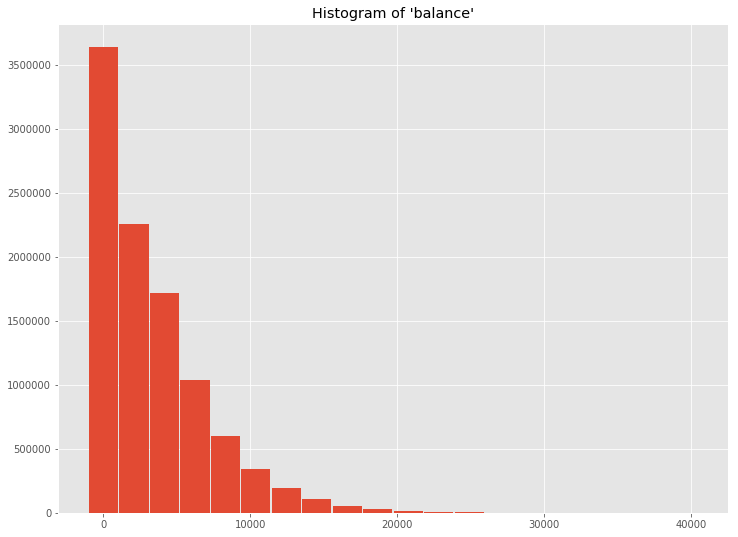

In [32]:
data = {
    'bins': hists[0][:-1],
    'freq': hists[1]
}

fig = plt.figure(figsize=(12,9))
ax = fig.add_subplot(1, 1, 1)
ax.bar(data['bins'], data['freq'], width=2000)
ax.set_title('Histogram of \'balance\'')

plt.savefig('B05793_05_22.png', dpi=300)

In [34]:
data_driver = {'obs': fraud_df.select('balance').rdd.flatMap(lambda row: row).collect()}

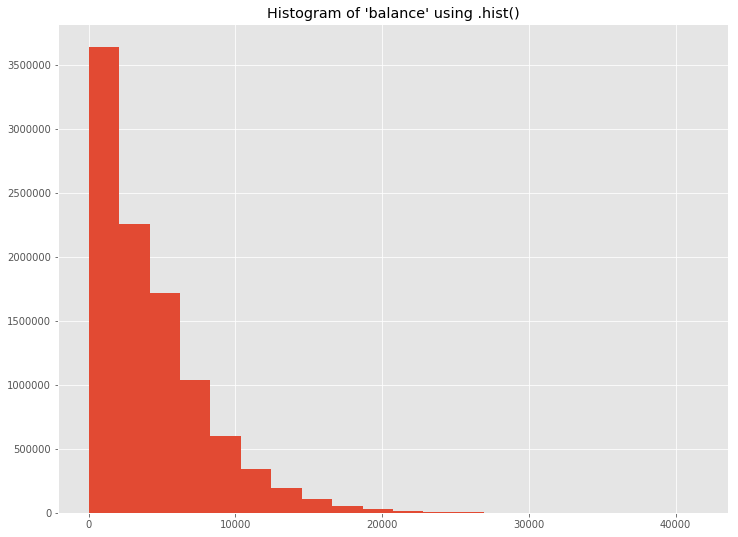

In [35]:
fig = plt.figure(figsize=(12,9))
ax = fig.add_subplot(1, 1, 1)

ax.hist(data_driver['obs'], bins=20)
ax.set_title('Histogram of \'balance\' using .hist()')


plt.savefig('B05793_05_24.png', dpi=300)